In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import skewnorm, skew, norm, shapiro

In [5]:
def gen_skewnormal(mean, var, alpha, size, random_state=None):
    # generate standard skew normal distribution
    X = skewnorm.rvs(alpha, loc=0, scale=1, size=size, random_state=random_state)
    
    # theory expectation value (mean) and variance of standard skew normal distribution
    tmean = np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    tvar = 1 - 2/np.pi * alpha**2 / (1+alpha**2)

    # (1)adjust var (2)adjust mean. Order can not reverse
    X = np.sqrt(var/tvar) * X
    tmean = np.sqrt(var/tvar) * np.sqrt(2/np.pi) * alpha / np.sqrt(1+alpha**2)
    X = X + mean - tmean
    
    return X

In [6]:
X = gen_skewnormal(5, 2, 4, 100000, 42)
X.var()

2.004927890730308

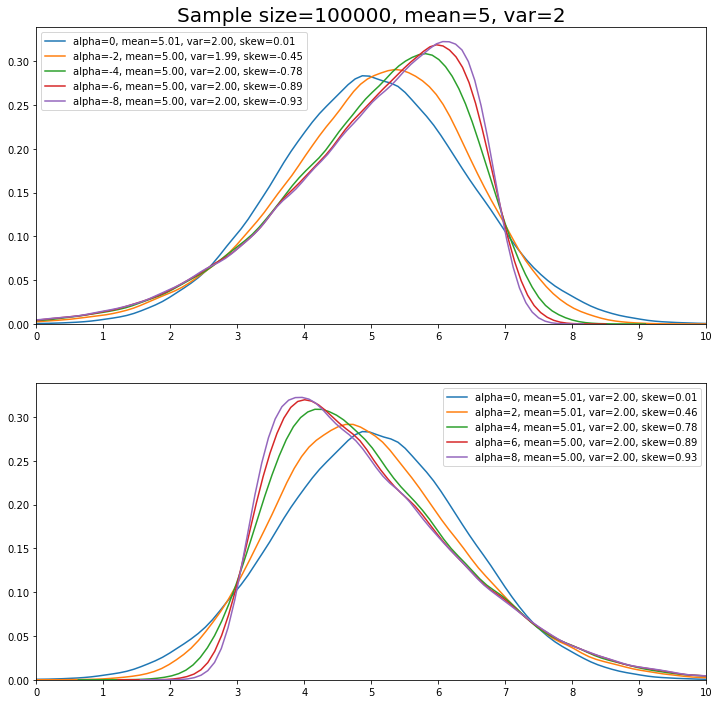

In [9]:
size = 100000
mean = 5
var = 2

fig, axs = plt.subplots(figsize=(12, 12), nrows=2)
for alpha in np.arange(0, 10, 2):
    alpha *= -1
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[0])

for alpha in np.arange(0, 10, 2):
    X = gen_skewnormal(mean, var, alpha, size, 42)
    sns.kdeplot(X, label=f'alpha={alpha}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}', ax=axs[1])
    
title = f'Sample size={size}, mean={mean}, var={var}'
axs[0].set_title(title, fontsize=20)
axs[0].set_xlim([mean-5, mean+5])
axs[0].set_xticks([i for i in range(0, 11)])
axs[1].set_xlim([mean-5, mean+5])
axs[1].set_xticks([i for i in range(0, 11)]);

,mean,var,skew,W,p-value
-1.6,0.001041,1.031497,-0.323,0.994,0.00000
-1.2,0.000524,1.036309,-0.192,0.998,0.00001
-0.8,-0.000137,1.039803,-0.073,1.000,0.39403
-0.4,-0.000925,1.039741,-0.002,1.000,0.99510
-0.0,-0.001752,1.034284,0.014,1.000,0.67355
0.4,-0.002480,1.024341,0.025,1.000,0.44451
0.8,-0.003018,1.013362,0.088,0.999,0.04178
1.2,-0.003363,1.004217,0.202,0.997,0.00000
1.6,-0.003563,0.997730,0.332,0.993,0.00000


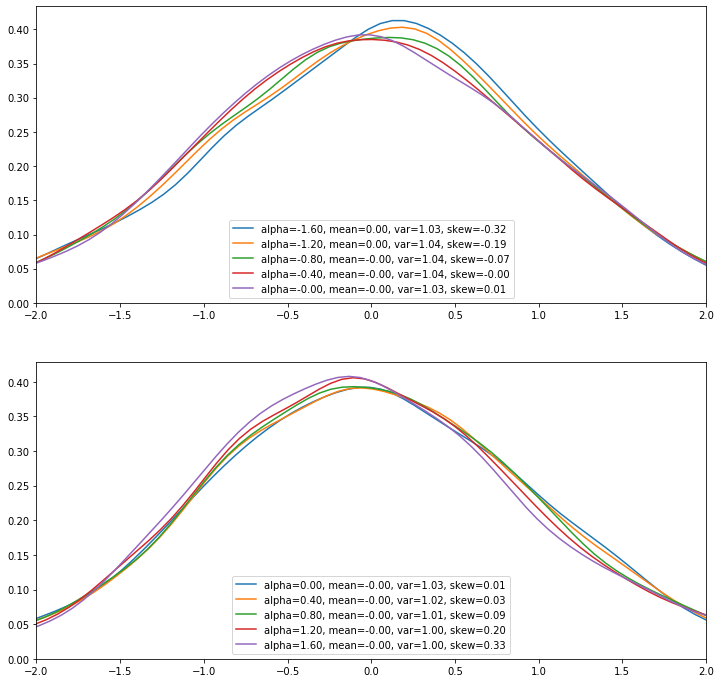

In [41]:
fig, axs = plt.subplots(figsize=(12, 12), nrows=2)

size = 4000
result = {}
for alpha in np.arange(-1.6, 0.2, 0.4):
    X = gen_skewnormal(0, 1, alpha, size, 42)
    W, p = shapiro(X)
    result[alpha] = [X.mean(), X.var(), skew(X), W, p]
    label = f'alpha={alpha:.2f}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}'
    sns.kdeplot(X, label=label, ax=axs[0])
    
for alpha in np.arange(0, 1.8, 0.4):
    X = gen_skewnormal(0, 1, alpha, size, 42)
    W, p = shapiro(X)
    if alpha != 0:
        result[alpha] = [X.mean(), X.var(), skew(X), W, p]
    label = f'alpha={alpha:.2f}, mean={X.mean():.2f}, var={X.var():.2f}, skew={skew(X):.2f}'
    sns.kdeplot(X, label=label, ax=axs[1])
    
axs[0].set_xlim([-2, 2])
axs[1].set_xlim([-2, 2])

"""
result = {}
for alpha in np.arange(-1.6, 1.8, 0.2):
    X = gen_skewnormal(0, 1, alpha, 4000, 42)
    W, p = shapiro(X)
    result[alpha] = [X.mean(), X.var(), skew(X), W, p]
"""

df = pd.DataFrame(result, index=['mean', 'var', 'skew', 'W', 'p-value']).T
df.index.name = 'alpha'

df_s = df.copy()
df_s.index = [f'{idx:.1f}' for idx in df_s.index]
df_s['skew'] = df_s['skew'].map(lambda y: f'{y:.3f}')
df_s['W'] = df_s['W'].map(lambda y: f'{y:.3f}')
df_s['p-value'] = df_s['p-value'].map(lambda y: f'{y:.5f}')
df_s

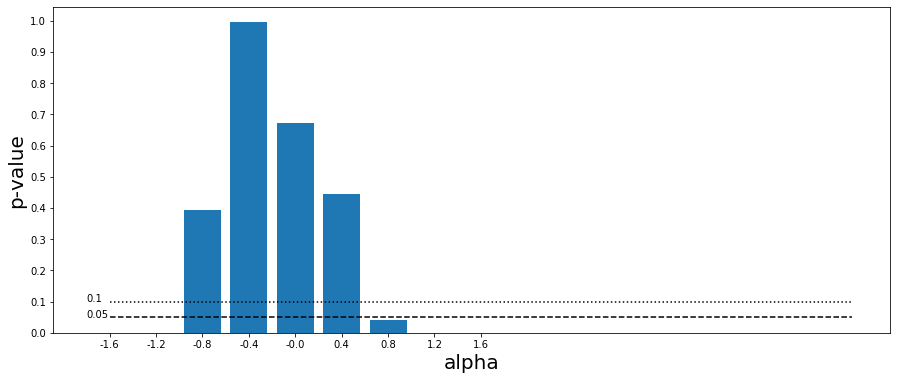

In [42]:
plt.figure(figsize=(15, 6))
x = df_s.index.values
p = df['p-value'].values
plt.bar(x, p)

plt.hlines(0.1, 0, 16, ls='dotted')
plt.hlines(0.05, 0, 16, ls='dashed')
plt.text(-0.5, 0.1, '0.1')
plt.text(-0.5, 0.05, '0.05')

plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('alpha', fontsize=20)
plt.ylabel('p-value', fontsize=20);

### 測試 skewnorm 的 sampling error。看樣本數要多少，用正負alpha各自計算出來的偏度才會同值異號

In [104]:
def tskew(alpha):
    """給定alpha, 計算理論的偏度值"""
    d = alpha / np.sqrt(1+alpha**2)
    return (4-np.pi)/2 * (d*np.sqrt(2/np.pi)) ** 3 / (1-2*d**2/np.pi) ** (3/2)

size = 50
alpha = 0.4:   skew=-0.41000317186041696
alpha = -0.4:  skew=-0.5980714493002802
size = 100
alpha = 0.4:   skew=0.32458469360670567
alpha = -0.4:  skew=0.1252732440970227
size = 1000
alpha = 0.4:   skew=0.0686216945355828
alpha = -0.4:  skew=0.07492605059759436
size = 10000
alpha = 0.4:   skew=0.06544623111396305
alpha = -0.4:  skew=-0.026676144342758154
size = 100000
alpha = 0.4:   skew=0.020463342036354873
alpha = -0.4:  skew=-0.01587378274734466
size = 1000000
alpha = 0.4:   skew=0.011804376972290836
alpha = -0.4:  skew=-0.014695722506315193
size = 2000000
alpha = 0.4:   skew=0.009898810452247712
alpha = -0.4:  skew=-0.012165315314825877
size = 5000000
alpha = 0.4:   skew=0.012588126343705661
alpha = -0.4:  skew=-0.011733314178587122


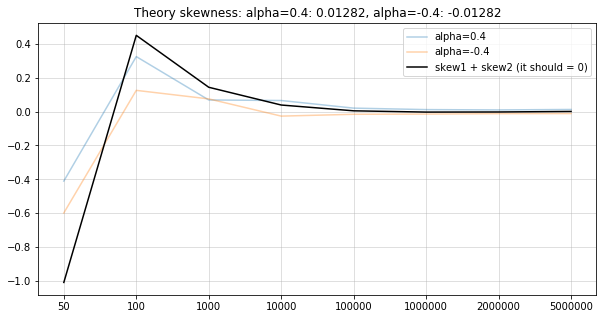

In [110]:
### alpha = 0.4 or -0.4

alpha = 0.4
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度，似乎要到萬等級的樣本數，偏度值才會比較穩定
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

size = 50
alpha = 2.5:   skew=0.544272540231308
alpha = -2.5:  skew=-0.8777334714879691
size = 100
alpha = 2.5:   skew=0.9100998457319511
alpha = -2.5:  skew=-0.721766486711864
size = 1000
alpha = 2.5:   skew=0.38670701590565504
alpha = -2.5:  skew=-0.5790169784514841
size = 10000
alpha = 2.5:   skew=0.5559927455777459
alpha = -2.5:  skew=-0.5338274403987184
size = 100000
alpha = 2.5:   skew=0.5809685187727608
alpha = -2.5:  skew=-0.5829316724136198
size = 1000000
alpha = 2.5:   skew=0.57545282285082
alpha = -2.5:  skew=-0.5782527520813135
size = 2000000
alpha = 2.5:   skew=0.5768935918477339
alpha = -2.5:  skew=-0.5752039958310811
size = 5000000
alpha = 2.5:   skew=0.5740379079266017
alpha = -2.5:  skew=-0.5753374737520612


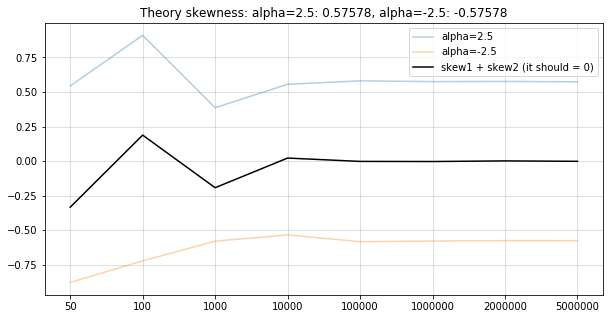

In [111]:
### alpha = 2.5 or -2.5

alpha = 2.5
sk1 = []
sk2 = []
test_size = [50, 100, 1000, 10000, 100000, 1000000, 2000000, 5000000]
for size in test_size:
    x1 = skewnorm.rvs(alpha, loc=0, scale=1, size=size)
    sk1.append(skew(x1))
    x2 = skewnorm.rvs(-alpha, loc=0, scale=1, size=size)
    sk2.append(skew(x2))
    print(f'size = {size}')
    print(f'alpha = {alpha}:   skew={skew(x1)}')
    print(f'alpha = {-alpha}:  skew={skew(x2)}')

# 計算skewnorm的樣本偏度
plt.figure(figsize=(10, 5))
plt.plot(sk1, alpha=0.35, label=f'alpha={alpha}')
plt.plot(sk2, alpha=0.35, label=f'alpha={-alpha}')

sk12 = [i+j for i, j in zip(sk1, sk2)]  # it should be zero, if no sampling error
plt.plot(sk12, color='k', label='skew1 + skew2 (it should = 0)')
plt.grid(True, alpha=0.5)
plt.xticks(ticks=range(len(test_size)), labels=test_size)
plt.legend()
plt.title(f'Theory skewness: alpha={alpha}: {tskew(alpha):.5f}, alpha={-alpha}: {tskew(-alpha):.5f}');

# 似乎alpha大時，算出來的樣本偏度比alpha小時還要更快收斂

#### 接下來的工作：負alpha的情況就不用管了，一律用正值去計算。找要做實驗的偏度時，因為前面顯示若alpha才0.4，且樣本只有千等級的話，算出來的樣本偏度可能誤差有點大，但是如果把樣本放大到更多，就沒辦法用shaoiro檢定了。使用 gen_skewnormal 時，樣本的平均和變異都和給定的差不多沒問題，不過樣本的偏度可能會有稍大的誤差，所以要順便計算理論的偏度值，多試幾次random_state，以樣本偏度與理論值最接近的那次為準